# Susceptibility Artifact Dataset
This project simulates a susceptibility artifact, and generates a CNN training dataset for the artifact.
Author: Martin Reinok (University of Twente)

## MRI Static settings for simulation

In [631]:
class FOV(object):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
B0 = 1.5  # Tesla
SLICE_THICKNESS = 10  # mm
SIMULATION_RESOLUTION = 300  # distribution of calculation points over chosen pixel resolution, capped at ~600 due to 24GB VRAM.
GYROMAGNETIC_RATIO = 42576384.7  # in Hz/T
P_XYZ = 1  # Assuming uniform signal producing spin density, p(x,y,z) can be taken as 1

## MRI variable settings for simulation
These may be changed for data augmentation

In [632]:
FOV = FOV(20, 20)
image_pixel_resolution = 512  # pixels
voxel_size = 1.2  # mm
echo_time_ms = 4.45  # ms
"""
Dynamic variables
Don't change these
"""
TE = echo_time_ms * 0.001  # seconds
delta_x_V = voxel_size * 0.01

## Use GPU for numpy calculations
cupy is used to distribute simulation to Nvidia GPU.

In [633]:
import cupy as cp
import numpy as np

if cp.cuda.runtime.getDeviceCount() > 1:
    if cp.cuda.Device(0).compute_capability > cp.cuda.Device(1).compute_capability:
        cp.cuda.Device(0).use()
    else:
        cp.cuda.Device(1).use()
else:
    cp.cuda.Device(0).use()

## Initialize simulation spatial range

In [634]:
x = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
y = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
z = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
X, Y, Z = cp.meshgrid(x, y, z)

## Simulation

In [635]:
import matplotlib.pyplot as plt
import helper_methods as helper

def quick_plot(data, cmap, size=None):
    if size:
        plt.figure(figsize=(size, size))
    plt.imshow(data, cmap=cmap)
    plt.tight_layout()
    plt.colorbar()
    plt.show()

### Dipole field
Based on paper:
**Passive tracking exploiting local signal conservation: the white marker phenomenon**
PMID: 14523965

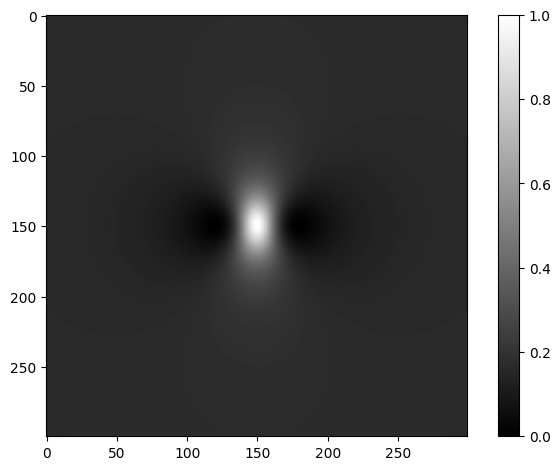

In [636]:
c = B0 * delta_x_V / (4 * cp.pi)
Bz = c * (X ** 2 + Y ** 2 - 2 * Z ** 2) / ((X ** 2 + Y ** 2 + Z ** 2) ** (5 / 2))
quick_plot(helper.normalize(cp.ndarray.get(Bz)[:, 125, :]), cmap="gray")

### Integration over slice direction

In [637]:
S_axial = 1 / SLICE_THICKNESS * cp.trapz(P_XYZ * cp.exp(-1j * GYROMAGNETIC_RATIO * Bz * TE), Z, axis=2)
S_coronal = 1 / SLICE_THICKNESS * cp.trapz(P_XYZ * cp.exp(-1j * GYROMAGNETIC_RATIO * Bz * TE), Y, axis=0)

### Data post-processing
- Cupy is converted to numpy
- np.angle and np.abs are used to separate phase and magnitude
- Data is normalized to 0-1 range
- Data is rotated by 90 degrees

In [638]:
coronal_phase = np.rot90(helper.normalize(np.angle(cp.asnumpy(S_coronal))))
coronal_magnitude = np.rot90(helper.normalize(np.abs(cp.asnumpy(S_coronal))))
axial_phase = np.rot90(helper.normalize(np.angle(cp.asnumpy(S_axial))))
axial_magnitude = np.rot90(helper.normalize(np.abs(cp.asnumpy(S_axial))))

#### Visualization

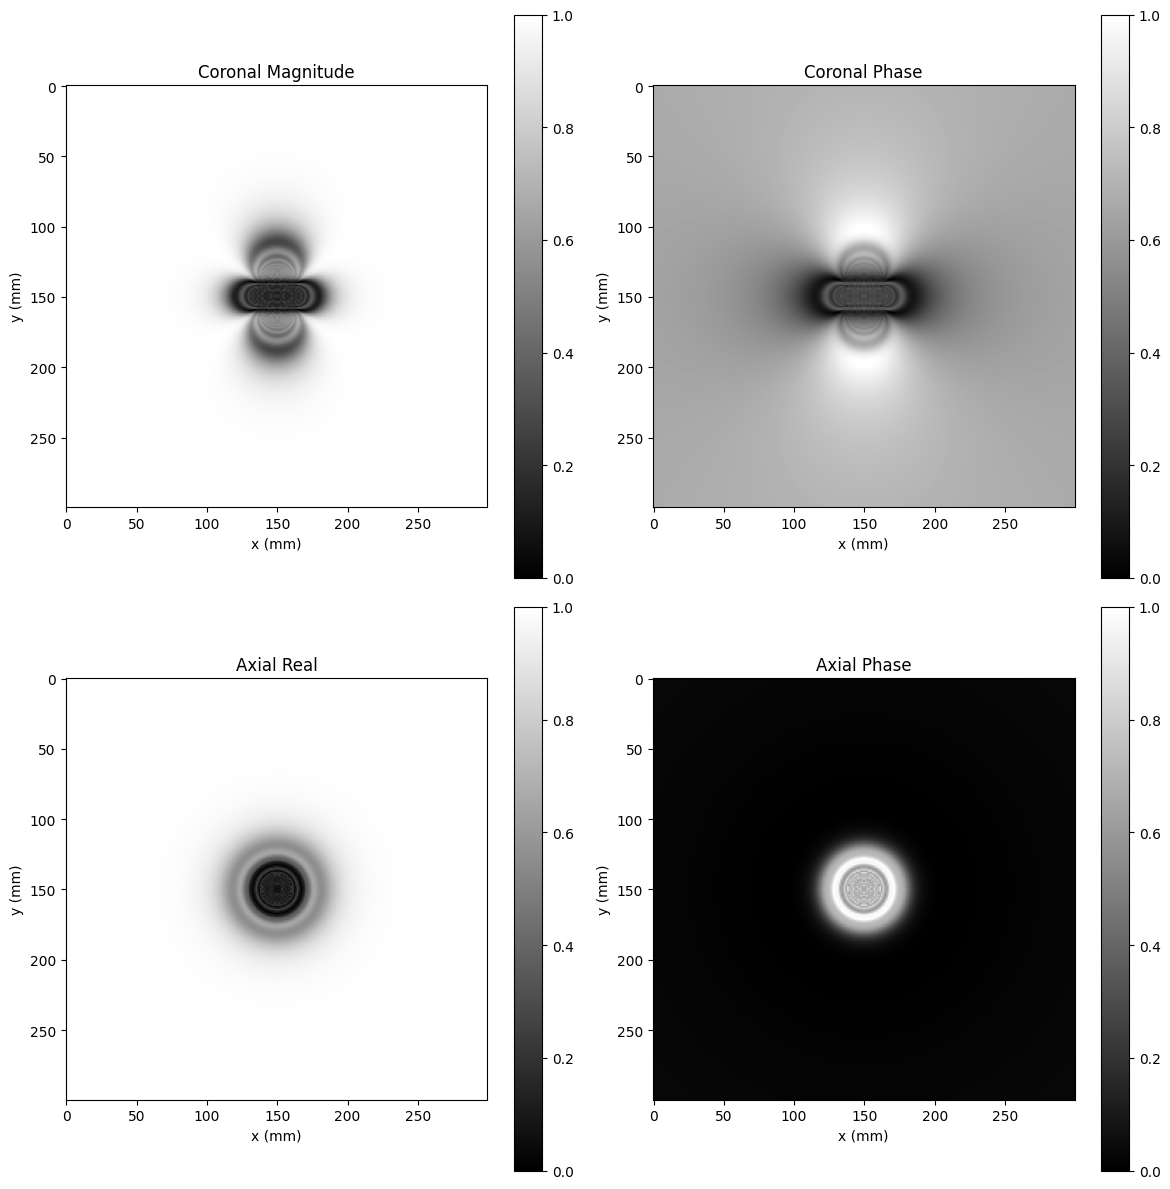

In [639]:
def group_plot(coronal_magnitude, coronal_phase, axial_magnitude, axial_phase,
               title1="Coronal Magnitude", title2="Coronal Phase", title3="Axial Real", title4="Axial Phase", cmap="gray", clim=None):
    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(coronal_magnitude, cmap="gray")
    plt.title(title1)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    if clim is not None:
        plt.clim(clim)
    plt.colorbar()
    
    if coronal_phase is not None:
        plt.subplot(2, 2, 2)
        plt.imshow(coronal_phase, cmap="gray")
        plt.title(title2)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
    
    if axial_magnitude is not None:
        plt.subplot(2, 2, 3)
        plt.imshow(axial_magnitude, cmap="gray")
        plt.title(title3)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
        
    if axial_phase is not None:
        plt.subplot(2, 2, 4)
        plt.imshow(axial_phase, cmap="gray")
        plt.title(title4)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()
group_plot(coronal_magnitude, coronal_phase, axial_magnitude, axial_phase)

### Adding a color LUT to match MRI bSSFP colors
N enforces that the data is 16bit.

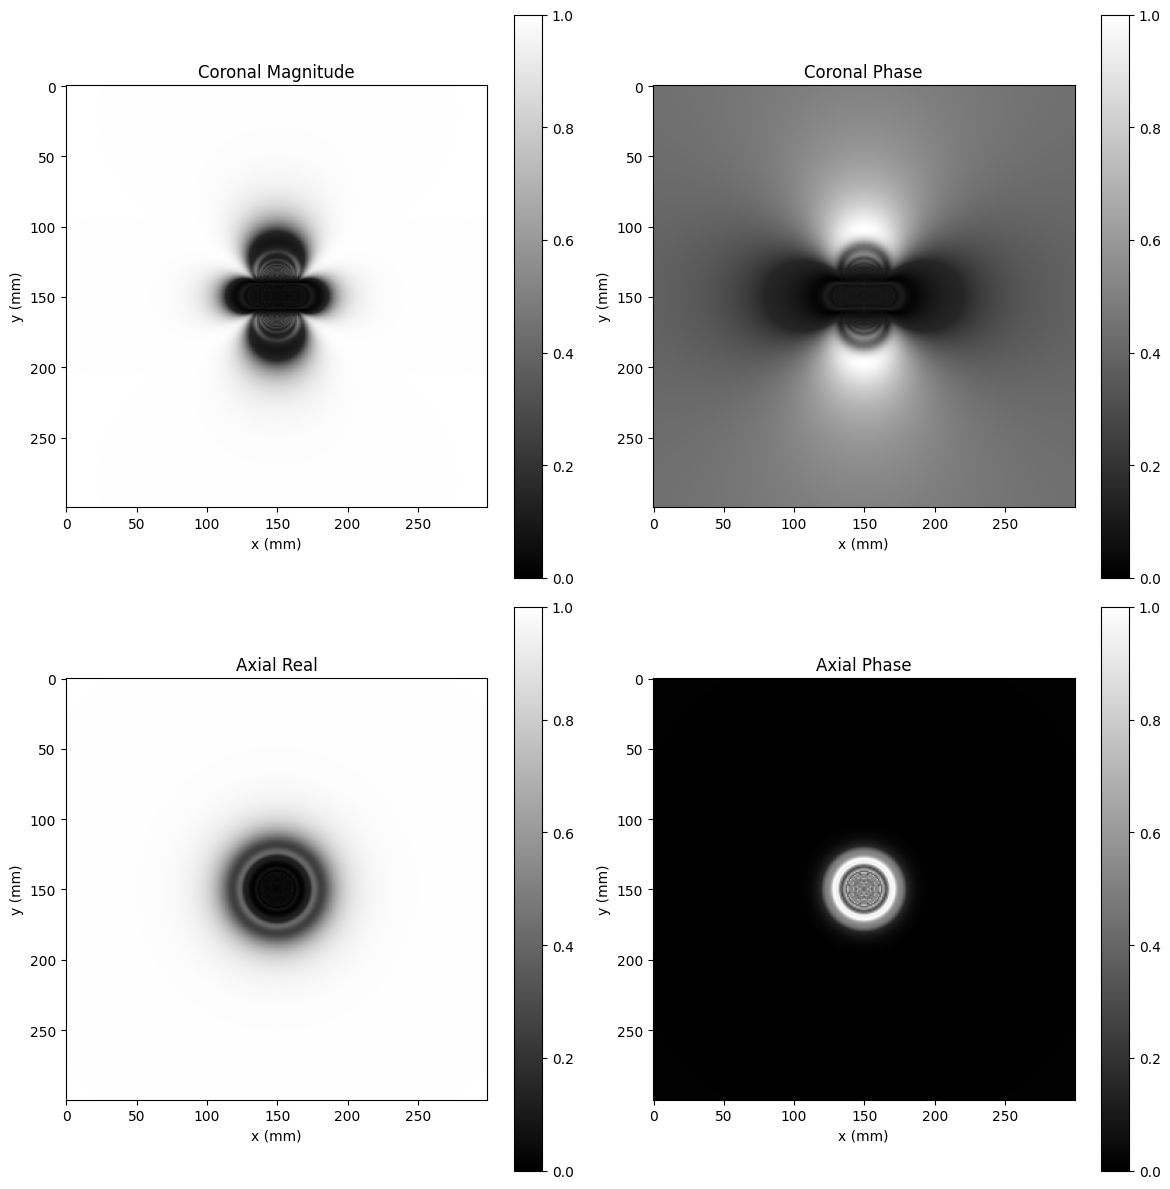

In [640]:
from matplotlib.colors import LinearSegmentedColormap
bSSFP_colors = [(0, (0, 0, 0)), (0.5, (0.15, 0.15, 0.15)), (1, (1, 1, 1))]
bSSFP_colors = LinearSegmentedColormap.from_list("", bSSFP_colors, N=65535)

coronal_phase_lut = bSSFP_colors(coronal_phase)
coronal_magnitude_lut = bSSFP_colors(coronal_magnitude)
axial_phase_lut = bSSFP_colors(axial_phase)
axial_magnitude_lut = bSSFP_colors(axial_magnitude)

group_plot(coronal_magnitude_lut, coronal_phase_lut, axial_magnitude_lut, axial_phase_lut)

## OpenCV
OpenCV is used for saving images, augmentation and superimposing.

### Converting data to OpenCV
OpenCV is restricted to mostly 8-bit data. Or 16-bit is hard to work with so this project is currently limited to 8-bit.
Not yet sure if this is an issue or not. There is some noticeable data loss, but might not matter.

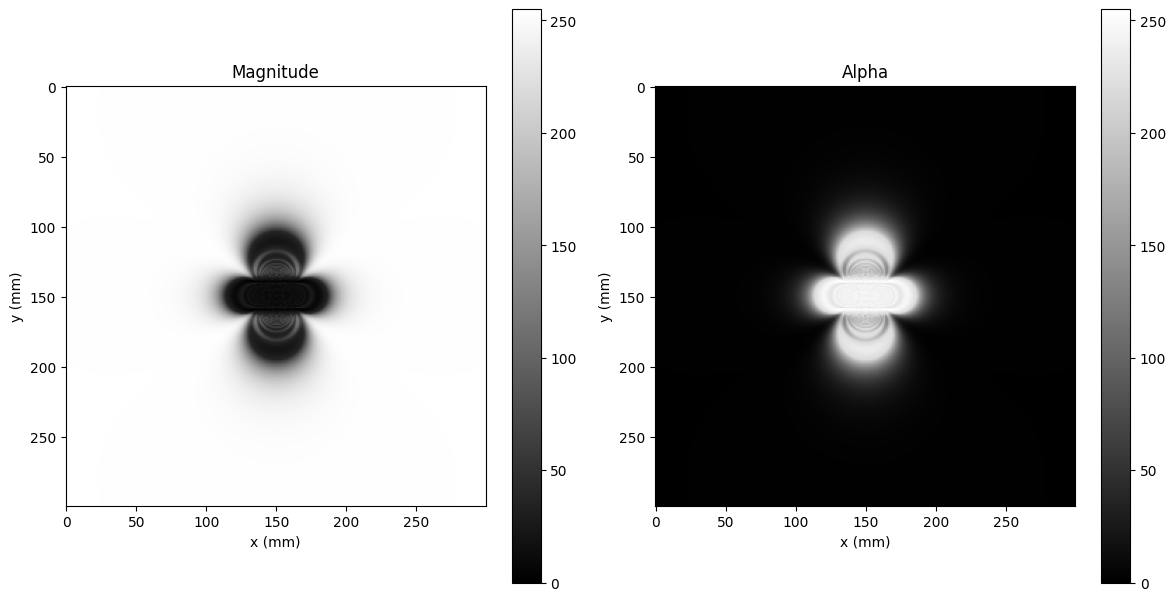

True

In [641]:
import cv2

def opencv_convert_16bit(magnitude):
    magnitude_16bit = (magnitude * 65535).astype(np.uint16)
    magnitude_16bit_gray = cv2.cvtColor(magnitude_16bit, cv2.COLOR_BGR2GRAY)
    return magnitude_16bit, magnitude_16bit_gray

def opencv_convert_8bit(magnitude):
    magnitude_8bit = (magnitude * 255).astype(np.uint8)
    magnitude_8bit = cv2.cvtColor(magnitude_8bit, cv2.COLOR_BGR2GRAY)
    magnitude_color_8bit = cv2.cvtColor(magnitude_8bit, cv2.COLOR_GRAY2RGB)
    magnitude_alpha_8bit = (255 - magnitude_8bit).round().astype(np.uint8)
    # pre-multiplied alpha
    magnitude_premult = cv2.cvtColor(cv2.merge((magnitude_color_8bit, magnitude_alpha_8bit)), cv2.COLOR_RGBA2mRGBA)
    return magnitude_8bit, magnitude_premult, magnitude_alpha_8bit
magnitude_8bit_gray, magnitude_premultiplied, magnitude_alpha = opencv_convert_8bit(coronal_magnitude_lut)

group_plot(magnitude_8bit_gray, magnitude_alpha, None, None, title1="Magnitude", title2="Alpha")
cv2.imwrite("test-images/magnitude_gray.png", magnitude_8bit_gray)
cv2.imwrite("test-images/magnitude_premult_alpha.png", magnitude_premultiplied)

### Example superimposing
- resize artifact uniformly
- create white image with the same dimensions as background image
- place artifact on the white image at specified location
- element-wise multiply background with the white image with marker

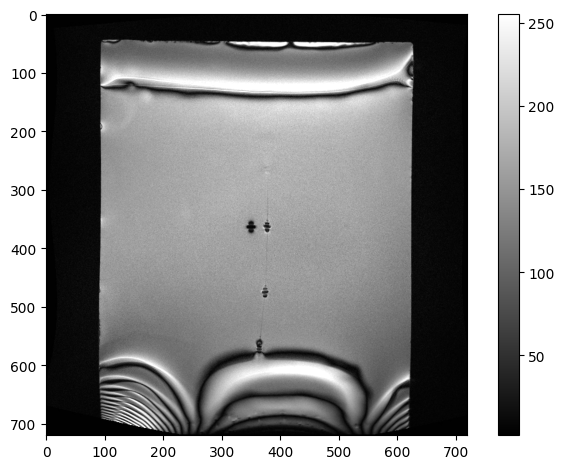

True

In [642]:
def superimpose_image(background, foreground, scale, position):
    x, y = position
    background = cv2.imread(background, cv2.IMREAD_GRAYSCALE)
    assert x < background.shape[0] and y < background.shape[0], AssertionError(f"Position coordinates out of range {background.shape}")
    background = background.astype(np.uint8)
    foreground = (foreground/255).astype(float)
    foreground = cv2.resize(foreground, (int(scale*foreground.shape[0]), int(scale*foreground.shape[0])))
    height, width = foreground.shape
    background_white = np.ones(background.shape, dtype=foreground.dtype)*1
    background_white[y:y+height, x:x+width] = foreground
    background = np.multiply(background, background_white)
    return background.astype(np.uint8)

superimposed_example = superimpose_image("background_dataset/00004.jpg", magnitude_8bit_gray, scale=0.2, position=(320, 335))
quick_plot(superimposed_example.astype(np.uint8), cmap="gray")
cv2.imwrite("test-images/superimposed_example.png", superimposed_example.astype(np.uint8))

# Data Augmentation
- Contrast
- Size variance
- Noise

## Weaken contrast
Only contrast reduction currently.

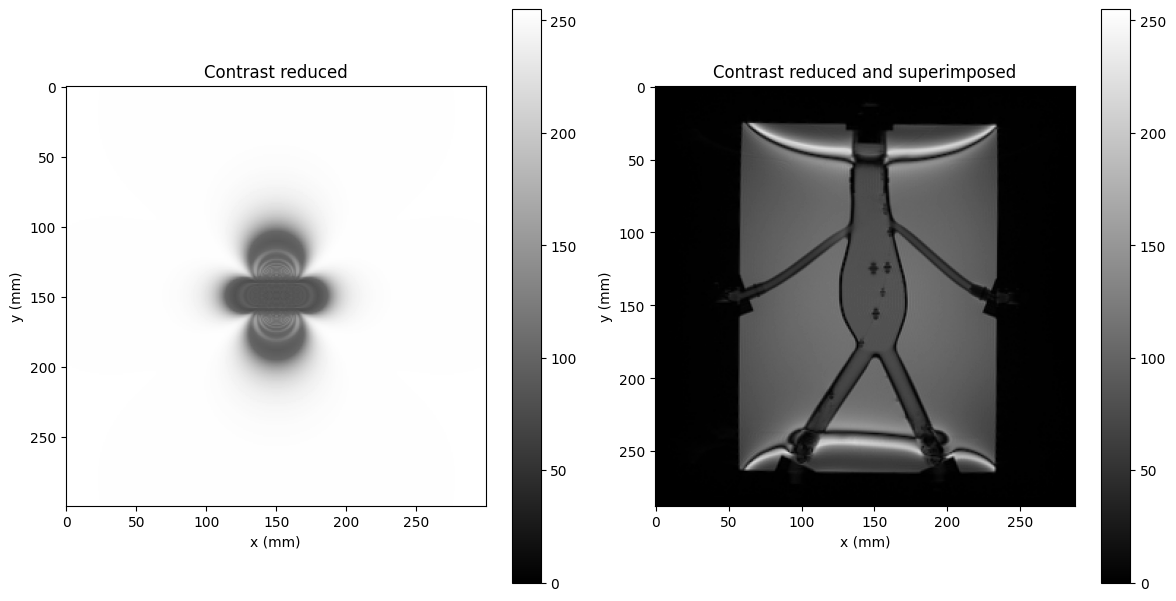

In [643]:
def adjust_contrast(image, scale):
        white_image = np.ones(image.shape, dtype=image.dtype) * 255
        adjusted_image = cv2.addWeighted(image, 0+scale, white_image, 1-scale, 0)
        return adjusted_image

reduced_contrast = adjust_contrast(magnitude_8bit_gray, 0.7)
superimposed_example = superimpose_image("background_dataset/00026.jpg", foreground=reduced_contrast, scale=0.077, position=(138, 114))
group_plot(reduced_contrast, superimposed_example, None, None,
           title1="Contrast reduced", title2="Contrast reduced and superimposed", clim=(0, 255))


In that particular image above, there are not that many pixels to work with, the width of artifact is approx 10 pixels.

## Noise
Noise is skipper right now, the resolution is too low for any noise.

# CNN training